# Assignment 2
### Predict stock market price for TESLA


# Chosing an algorithm

Document your findings in a file (3-5 lines) on why you chose this algorithm.

# Imports

In [4043]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Reading the data

In [4044]:
# We read the data from the csv file
data = pd.read_csv('data/TESLA.csv')

# We call info() to check if there are any null values or object types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3357 non-null   object 
 1   Open       3357 non-null   float64
 2   High       3357 non-null   float64
 3   Low        3357 non-null   float64
 4   Close      3357 non-null   float64
 5   Adj Close  3357 non-null   float64
 6   Volume     3357 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 183.7+ KB


In [4045]:
# We transform the Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

In [4046]:
# Describe to check range of values
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,3357,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3.357000e+03
mean,2017-02-26 05:51:18.820375296,68.372233,69.892698,66.736911,68.350852,68.350852,9.650271e+07
min,2010-06-29 00:00:00,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,2013-10-28 00:00:00,10.166667,10.498667,9.917333,10.162667,10.162667,4.549350e+07
50%,2017-02-28 00:00:00,16.803333,17.049334,16.566668,16.809334,16.809334,8.041650e+07
75%,2020-06-29 00:00:00,67.456665,68.498665,66.297997,68.336670,68.336670,1.230810e+08
max,2023-10-27 00:00:00,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08
std,NaN,100.435123,102.699392,97.945596,100.352800,100.352800,8.048337e+07


We can also plot the data to get a better understanding

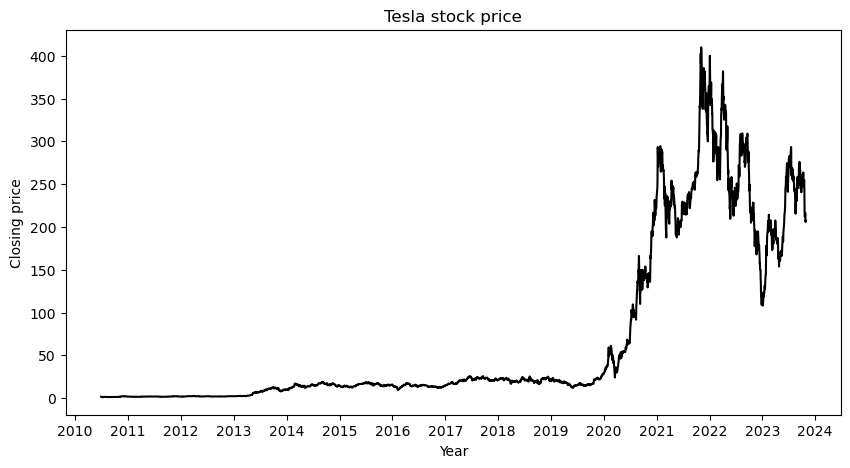

In [4047]:
# We create a plot showing the closing price of Tesla stock labeled by year
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Close'], color='black')
plt.title('Tesla stock price')
plt.xlabel('Year')
plt.ylabel('Closing price')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.show()

From the plot we can see that the value skyrocketed in 2020 and the price is more volatile. We might need to keep this in mind when training our model. The predictions are probably more accurate for the period before 2020.

# Preparing the data

In [4048]:
# We create a new dataframe with only the Date and Close columns
df = data[['Date', 'Close']].copy()

# We separate the Date column into Year, Month, day and DayOfWeek columns to use them as features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Set the Date column as the index
df.set_index('Date', inplace=True, drop=True)

# Move Column Close to the end
df = df[[c for c in df if c not in ['Close']] + ['Close']]

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3357 non-null   datetime64[ns]
 1   Close   3357 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 52.6 KB


,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000


In [4049]:
# Split the dataframe into features X and target Y
X = df.drop(['Close'], axis=1)
Y = df['Close']

# We also split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1)

# We create a GradientBoostingRegressor model with default parameters
model = GradientBoostingRegressor()

# We fit the model to the training data
model.fit(x_train, y_train)

GradientBoostingRegressor()

In [4050]:
# We calculate the mean squared error of the model
mse = mean_squared_error(y_test, model.predict(x_test))
print('The mean squared error is: {:.4f}'.format(mse))

The mean squared error is: 30.2825


# Hyperparameter tuning

In order to improve the performance of the model we can tune the hyperparameters. We will use the function RandomizedSearchCV to find a better set of parameters.

## Tuning function

In [4051]:
# This function will train a model with different parameters, return the best model and print the best parameters
def get_best_estimator(model, iterations=250):
    # We create a dictionary with the parameters we want to test
    distrubutions = {
        'n_estimators': [100, 250, 500, 750, 1000],
        'max_depth': [2, 3, 4, 5, 6],
        'min_samples_split': [2, 3, 4, 5],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'criterion': ['friedman_mse', 'mse'],
        'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    }

    # We create a RandomizedSearchCV object
    search = RandomizedSearchCV(
        model,
        param_distributions=distrubutions,
        n_iter=iterations,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        cv=5,
    )

    # We fit the model to the training data
    search.fit(x_train, y_train)

    # We get the best model
    best_estimator = search.best_estimator_

    # We get the best parameters
    best_params = search.best_params_

    # We print the best parameters
    print('The best model has the following parameters:')
    print(best_params)

    # Return the best model and best parameters from the RandomizedSearchCV
    return best_estimator

## Training

In [4052]:
# These params are the result from prevoiusly running get_best_estimator function
# We can now use these params to create a new model without having to rerun the function
params = {'n_estimators': 500,
          'min_samples_split': 2,
          'max_depth': 3,
          'loss': 'squared_error',
          'learning_rate': 0.1}

# We create a new GradientBoostingRegressor model with default parameters
model_tuned = GradientBoostingRegressor(**params)

# We fit the model to the training data
model_tuned.fit(x_train, y_train)

# If you want to run the get_best_estimator function you can uncomment the line below.
# Change the number of iterations to a higher number if you want to test more parameters
# model_new = get_best_estimator(model, 250)

GradientBoostingRegressor(n_estimators=500)

## Evaluation

In [4053]:
# We calculate the mean squared error of the tuned model
mse_new = mean_squared_error(y_test, model_tuned.predict(x_test))
print('The mean squared error (MSE) on test set: {:.4f}'.format(mse_new))

The mean squared error (MSE) on test set: 18.5754


In [4054]:
# Lets look at the improvement in MSE compared to the default model
print('The mean squared error (MSE) improvement: {:.2f}%'.format(
    (mse - mse_new) / mse * 100))

The mean squared error (MSE) improvement: 38.66%


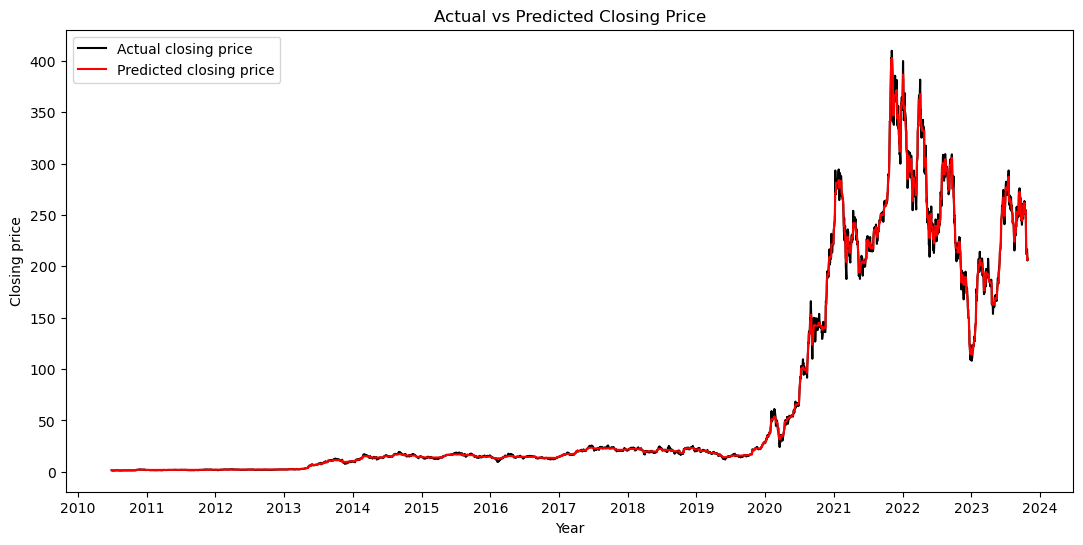

In [4055]:
# We create a plot showing the actual closing price and the predicted closing price
prediction = model_tuned.predict(X)

plt.figure(figsize=(13, 6))
plt.plot(df['Date'], Y, color='black', label='Actual closing price')
plt.plot(df['Date'], prediction, color='red', label='Predicted closing price')
plt.xlabel('Year')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.ylabel('Closing price')
plt.title('Actual vs Predicted Closing Price')
plt.legend()
plt.show()

# Testing future dates

In [4056]:
# Function to predict the closing price of Tesla stock for a given date
def predict_closing_price(model, date):
    # We create a dataframe with the given date
    df_test = pd.DataFrame({'Date': [date]})

    # We create a new dataframe with only the Date column
    X = df_test[['Date']].copy()

    # We predict the closing price of the given date
    predicted_price = model.predict(X)[0]

    # We print the predicted price
    print('The predicted closing price of Tesla stock for {} is: ${:.2f}'.format(
        date.strftime('%Y-%m-%d'), predicted_price))

In [4057]:
# Test the function with a date
predict_closing_price(model_tuned, pd.to_datetime('2023-10-30'))
predict_closing_price(model, pd.to_datetime('2023-10-30'))

The predicted closing price of Tesla stock for 2023-10-30 is: $207.67
The predicted closing price of Tesla stock for 2023-10-30 is: $213.74


# Further improvements

We created a model that predicts the closing price of Tesla stock based only on features derived from the date. Ideally we would like to use more features to improve the performance of the model. We would also be more likely to get a meaningful result if we turned this into a classification problem to only predict if the price will go up or down, based on a set of features and a series of historical data.